In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LinearRegression,SGDRegressor
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("WasLetztePreis/WasLetztePreis_training.csv")

In [3]:
df

,id,preis,marke,model,bauform,kraftstoff,getriebe,ps,kilometerstand,erstzulassung,gebiet,verkaufsdatum
0,100000,1000.0,audi,80,limousine,benzin,manuell,90,150000,1994,25853,2016-03-20
1,100001,23750.0,volkswagen,golf,limousine,benzin,automatik,230,60000,2013,31812,2016-03-28
2,100002,6750.0,bmw,3er,coupe,benzin,automatik,192,100000,2001,24398,2016-04-07
3,100003,9750.0,volkswagen,kaefer,limousine,NaN,NaN,0,40000,1985,48163,2016-03-21
4,100004,19999.0,mercedes_benz,c_klasse,cabrio,benzin,manuell,156,40000,2011,74078,2016-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,NaN,opel,corsa,kleinwagen,benzin,manuell,75,150000,2002,48429,2016-03-21
249996,349996,NaN,honda,jazz,kleinwagen,benzin,manuell,99,50000,2012,22880,2016-03-28
249997,349997,NaN,volkswagen,golf,kleinwagen,benzin,manuell,75,150000,1998,79713,2016-04-04
249998,349998,NaN,audi,a3,limousine,diesel,manuell,140,125000,2007,83730,2016-04-07


In [91]:
traindata = df.loc[df["preis"].notnull()]
traindata = traindata[(traindata["erstzulassung"] < 2020) & (traindata["erstzulassung"] > 1950)]

In [92]:
marken_dummies = pd.get_dummies(traindata["marke"]).add_prefix("marke_")
bauform_dummies = pd.get_dummies(traindata["bauform"]).add_prefix("bauform_")
kraftstoff_dummies = pd.get_dummies(traindata["kraftstoff"]).add_prefix("kraftstoff_")
getriebe_dummies = pd.get_dummies(traindata["getriebe"]).add_prefix("getriebe_")

In [89]:
traindata["preis"].describe()

count    200000.000000
mean       6551.737180
std        7495.612674
min         755.000000
25%        1800.000000
50%        3800.000000
75%        8490.000000
max       74999.000000
Name: preis, dtype: float64

In [87]:
verkaufsjahr = traindata["verkaufsdatum"].map(lambda s: int(s.split("-")[0]))
alter = verkaufsjahr - traindata["erstzulassung"]


,id,preis,marke,model,bauform,kraftstoff,getriebe,ps,kilometerstand,erstzulassung,gebiet,verkaufsdatum
0,100000,1000.0,audi,80,limousine,benzin,manuell,90,150000,1994,25853,2016-03-20
1,100001,23750.0,volkswagen,golf,limousine,benzin,automatik,230,60000,2013,31812,2016-03-28
2,100002,6750.0,bmw,3er,coupe,benzin,automatik,192,100000,2001,24398,2016-04-07
3,100003,9750.0,volkswagen,kaefer,limousine,NaN,NaN,0,40000,1985,48163,2016-03-21
4,100004,19999.0,mercedes_benz,c_klasse,cabrio,benzin,manuell,156,40000,2011,74078,2016-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,299995,7500.0,opel,astra,cabrio,benzin,manuell,200,125000,2003,79761,2016-04-05
199996,299996,20999.0,mini,cooper,coupe,benzin,manuell,184,50000,2013,94255,2016-04-06
199997,299997,2350.0,mazda,3_reihe,limousine,benzin,manuell,105,125000,2005,92237,2016-04-06
199998,299998,22500.0,bmw,x_reihe,limousine,diesel,automatik,177,60000,2011,82054,2016-04-06


In [37]:
gebiet_dummies = pd.get_dummies(traindata["gebiet"] // 10000).add_prefix("gebiet_")
gebiet_dummies

,gebiet_0,gebiet_1,gebiet_2,gebiet_3,gebiet_4,gebiet_5,gebiet_6,gebiet_7,gebiet_8,gebiet_9
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
199995,0,0,0,0,0,0,0,1,0,0
199996,0,0,0,0,0,0,0,0,0,1
199997,0,0,0,0,0,0,0,0,0,1
199998,0,0,0,0,0,0,0,0,1,0


In [93]:
train2 = pd.concat([traindata[["ps", "kilometerstand", "erstzulassung", "gebiet"]], marken_dummies, bauform_dummies, kraftstoff_dummies, getriebe_dummies], axis=1)

In [97]:
kraftstoff_dummies.sum()

kraftstoff_andere         61
kraftstoff_benzin     122204
kraftstoff_cng           201
kraftstoff_diesel      60287
kraftstoff_elektro        53
kraftstoff_hybrid        173
kraftstoff_lpg          3169
dtype: int64

In [94]:
train2.columns

Index(['ps', 'kilometerstand', 'erstzulassung', 'gebiet', 'marke_alfa_romeo',
       'marke_audi', 'marke_bmw', 'marke_chevrolet', 'marke_chrysler',
       'marke_citroen', 'marke_dacia', 'marke_daewoo', 'marke_daihatsu',
       'marke_fiat', 'marke_ford', 'marke_honda', 'marke_hyundai',
       'marke_jaguar', 'marke_jeep', 'marke_kia', 'marke_lada', 'marke_lancia',
       'marke_land_rover', 'marke_mazda', 'marke_mercedes_benz', 'marke_mini',
       'marke_mitsubishi', 'marke_nissan', 'marke_opel', 'marke_peugeot',
       'marke_porsche', 'marke_renault', 'marke_rover', 'marke_saab',
       'marke_seat', 'marke_skoda', 'marke_smart', 'marke_sonstige_autos',
       'marke_subaru', 'marke_suzuki', 'marke_toyota', 'marke_trabant',
       'marke_volkswagen', 'marke_volvo', 'bauform_cabrio', 'bauform_coupe',
       'bauform_kleinwagen', 'bauform_kombi', 'bauform_limousine',
       'bauform_suv', 'kraftstoff_andere', 'kraftstoff_benzin',
       'kraftstoff_cng', 'kraftstoff_diesel', 'krafts

In [98]:
# regr = make_pipeline(StandardScaler(), RandomForestRegressor())
regr = make_pipeline(StandardScaler(), RandomForestRegressor())
# regr = make_pipeline(RandomForestRegressor())


In [99]:
lr = LinearRegression()

X_train = train2.values
 
Y_train = traindata["preis"]
 
# lr.fit(X_train,Y_train)  
regr.fit(X_train,Y_train)  

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [100]:
Y_predict = regr.predict(X_train)

diff = Y_predict - Y_train

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.26067794e-04, 1.26067794e-04,
        0.00000000e+00, 5.04271177e-04, 7.56406765e-04, 4.53844059e-03,
        1.66409488e-02, 4.52583381e-02, 1.05392676e-01, 2.30073724e-01,
        4.90403720e-01, 9.59628050e-01, 1.72901980e+00, 3.03899025e+00,
        4.91576150e+00, 4.46267385e+00, 2.61603280e+00, 1.67922302e+00,
        1.12565933e+00, 7.94227104e-01, 5.80668260e-01, 4.26361280e-01,
        3.45930027e-01, 2.59195385e-01, 2.06499047e-01, 1.80024810e-01,
        1.37918167e-01, 1.15099896e-01, 8.87517271e-02, 7.69013545e-02,
        6.68159309e-02, 5.38309481e-02, 4.85361008e-02, 4.51322703e-02,
        3.20212197e-02, 2.84913215e-02, 2.71045758e-02, 2.11793894e-02,
        2.64742368e-02, 1.80276946e-02]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -

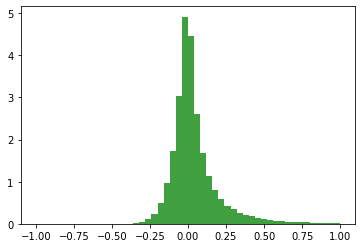

In [101]:
reldiff = (Y_predict - Y_train) / Y_train
plt.hist(reldiff, 50, range=(-1, 1), density=True, facecolor='g', alpha=0.75)

In [106]:
testdata = df.loc[df["preis"].isnull()]

marken_dummies1 = pd.get_dummies(testdata["marke"]).add_prefix("marke_")
bauform_dummies1 = pd.get_dummies(testdata["bauform"]).add_prefix("bauform_")
kraftstoff_dummies1 = pd.get_dummies(testdata["kraftstoff"]).add_prefix("kraftstoff_")
getriebe_dummies1 = pd.get_dummies(testdata["getriebe"]).add_prefix("getriebe_")
gebiet_dummies1 = pd.get_dummies(testdata["gebiet"] // 10000).add_prefix("gebiet_")

verkaufsjahr1 = testdata["verkaufsdatum"].map(lambda s: int(s.split("-")[0]))
alter1 = verkaufsjahr1 - testdata["erstzulassung"]

test2 = pd.concat([testdata[["ps", "kilometerstand", "erstzulassung", "gebiet"]], marken_dummies1, bauform_dummies1, kraftstoff_dummies1, getriebe_dummies1], axis=1)

In [107]:

Y = regr.predict(test2.values)

In [108]:
solution = pd.DataFrame({"id": testdata["id"], "preis": Y})

In [109]:
svs = solution.values

svs[:10][2]

array([300002.    ,   2862.5515])

In [110]:
with open("letztepreis_solution1.txt", "w") as f:
    f.write("50fd85bdaa1c8d7b910d4602121085fa2e62616635e7d9593ed80d721db68b90\n")
    f.write("wlp-test8\n")
    f.write("\n".join([str(int(line[0])) + " " + str(int(line[1])) for line in svs]) + "\n")